In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy

import numpy as np
from scipy import ndimage

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import download_file, clear_download_cache

import matplotlib.pyplot as plt
from matplotlib import colors

In [17]:
from unagi import config
from unagi import hsc
from unagi import plotting
from unagi.task import hsc_psf

pdr2 = hsc.Hsc(dr='pdr2', rerun='pdr2_wide')

# Get table list from /Users/song/Dropbox/work/project/unagi/unagi/data/pdr2_wide/pdr2_wide_tables.fits


## Imfit 2-D image fitting or decomposition

* In this notebook we will go through some of the basics for image fitting using [`imfit`](https://www.mpe.mpg.de/~erwin/code/imfit/) by Peter Erwin. 
* We will use the edge-on galaxy from `image_mask.ipynb` as an example. This is designed for a undergraduate-level research project at Princeton University.

### Preparation

#### Install `imfit`

* `imfit` is a commad-line tool written in C++. You should install it separately following the instruction on the website. 
    - If you are using typical MacOS or Linux environment, you should be able to just download the pre-compiled package, decompress it into a folder, and point the `imfit` executable binary file to your `PATH` environment variable.
    - If you have trouble doing that, you should follow the instruction and install it manually using a tool called `scons`. You can install it using your favorite package manager (`brew` for MacOS, `apt` for Ubuntu, etc). 
* You should read the [online tutorial](https://www.mpe.mpg.de/~erwin/code/imfit/markdown/index.html) and understand the basic procedure for image fitting.
    - There is also a pretty useful [online document](https://imfit.readthedocs.io/en/latest/) that gives you more details.
* `imfit` is open-source code. If you would like to understand more details, you can find all the source codes on [github](https://github.com/perwin/imfit). 

#### Python wrapper. 

* We want to use `imfit` within `Python` instead of typing commands into a terminal everytime.
* We are going to use the Python wrapper by the author of `imfit`. It is called [`pyimfit`](https://github.com/perwin/pyimfit).

##### Install `pyimfit`:

* Simply do `pip3 install --upgrade pyimfit` shoud do.

Now you should be able to `import pyimfit` in your Python environment. 

* `pyimfit` does not provide a lot of demos yet, but there is a pretty solid [on-line documentation](https://pyimfit.readthedocs.io/en/latest/) 

In [4]:
import pyimfit

pyimfit.__file__

'/usr/local/lib/python3.7/site-packages/pyimfit/__init__.py'

#### Prepare the input data 

Before fitting any image, you normally need a checklist for a five-component input list:
  - [ ] Input **science image**, a 2-D flux map: This is the one downloaded from HSC archive
  - [ ] Information about the uncertainty of the flux measurements, either in the form of **variance or sigma map**: the variance map is directly downloaded from HSC archive too.
  - [ ] **Object mask** to exclude the region you do not want to include in the fitting process: this is what we generated using our own object detection, deblending, and masking algorithm. You want to save the mask in `FITS` format.
  - [ ] **PSF image**, 2-D relative flux distribution of the point spread function. The model image will be convolved with the PSF model to match the observation. We will show you how to download that from HSC archive later.
  - [ ] **Model configuration**. Basically, we are using one particular or a combination of **parametric models** to describe the flux distribution of galaxies. There are many different types of components with different advantages and disadvantages. They are also described by different sets of free parameters we want to fit. Generally speaking, there is always a parameter that decides the typical flux amplitude, one for the typical size of the component, and something about the slope of the flux distribution. To fit a 2-D image, you also need to consider the shape (ellipticity and position angle).
    - You can find descriptions of available models in `imfit` [here](https://pyimfit.readthedocs.io/en/latest/defining_models.html)
    - If you want more details, you can find them in the [Appendix A (starting at Page 46) of the imfit PDF document](http://www.mpe.mpg.de/~erwin/resources/imfit/imfit_howto.pdf)

##### Prepare the input image and variance map 

In [8]:
cutout_edge = fits.open('edgeon_demo_i.fits')

# Science image
i_img = cutout_edge[1].data

# Variance map; both are 2-D numpy array
i_var = cutout_edge[3].data

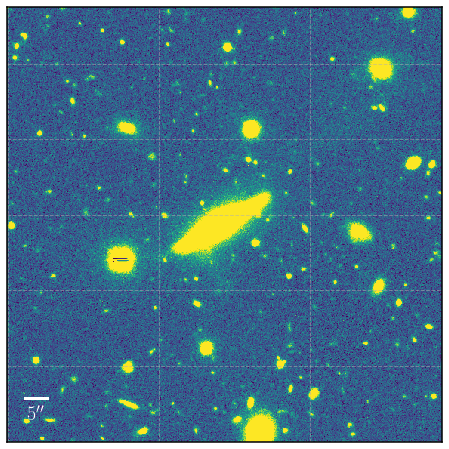

In [44]:
_ = plotting.display_single(i_img)

In [36]:
# We also want to know the size of the image and the pixel coordinate for the galaxy center
img_shape = i_img.shape

cen_x, cen_y = img_shape[0] / 2., img_shape[1] / 2.

print(img_shape, cen_x, cen_y)

# Also need to know the central flux level
cen_flux = i_img[int(cen_x), int(cen_y)]

(576, 576) 288.0 288.0


In [121]:
# We also want to know the average sky background value and its scatter 
from photutils import make_source_mask
from astropy.stats import sigma_clipped_stats

mask = make_source_mask(i_img, nsigma=1.5, npixels=4, dilate_size=15)
bkg_avg, bkg_med, bkg_std = sigma_clipped_stats(i_img, sigma=2.5, mask=mask)

print("# Mean sky background: {:f}".format(bkg_med))
print("# Uncertainty of sky background: {:f}".format(bkg_std))

# Mean sky background: 0.001787
# Uncertainty of sky background: 0.048771


##### Prepare the object mask we made

In [9]:
i_msk = fits.open('edgeon_demo_i_mask.fits')[0].data

##### Prepare the PSF image

# Retrieving coadd PSF model in filter: i


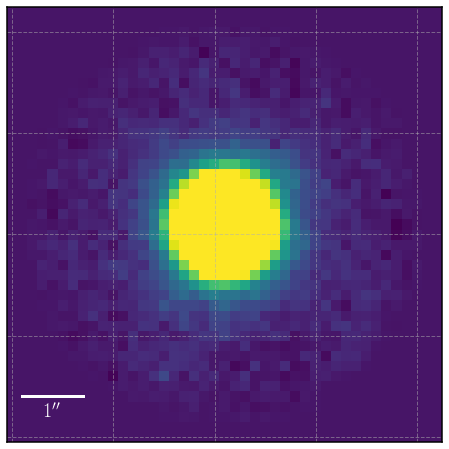

In [18]:
# Define a coordinate using the center of the galaxy
ra_obj, dec_obj = 177.56837, -0.396286
coord = SkyCoord(ra_obj, dec_obj, frame='icrs', unit='deg')

# This command will download PSF image from HSC archive. 
# It will take a few seconds, so it is better to download all the necessary ones at once.
psf_model = hsc_psf(coord, filters='i', archive=pdr2, prefix='edgeon_demo')

i_psf = psf_model[0].data

# PSF looks boring. It is basically a Gaussian function with some small deviations. 
# Basically, it is what a star looks like on HSC image
_ = plotting.display_single(i_psf, contrast=0.1, scale_bar_length=1.0)

### Build a `pyimfit` model object

We are going to use the following components in the fitting:

1. `EdgeOnDisk` -- The analytic form of an edge-on exponential disk (van der Kruit & Searle 1981), using the Bessel-function solution of van der Kruit & Searle (1981) for the radial profile and the generalized sech function of van der Kruit (1988) for the vertical profile. Geometric parameters: `PA`
    - In the beginning, we are going to only fit these edge-on galaxies with one `EdgeOnDisk` component.
    - The `EdgeOnDisk` model is described by the equation: $I(r,z) = 2rL_{0}\ K_{1}(r/h)\ {\rm sech}^{2/n}(n\times z/ (2z_0))$
    - Where $r$ is the distance from the galaxy center along the disk; $z$ is the distance perpendicular to the disc (or heigh from the disk).
    - $h$ is the **scale length** of the disk (meaning that the flux density of disk decrease to $1/e$ at a distance of $h$; similarly, $z_0$ is the **scale height** of the disc (in the direction of $z$)
    - $K_1(r/h)$ here is a special function: the modified Bessel function.
    - $n$ is another parameter that determines the behavior of the disc along the $z$ direction. When $n>>1$, it starts to look like an pure exponential profile; when $n=1$, it is described by a ${\rm sech}^2$ function.
2. `FlatSky` -- Produces a constant background for the entire image.
    - It only has one parameter, which is the average sky value. It is useful when you suspect the image has an over- or under-subtracted sky background. It can be negative when sky is oversubtracted.
    
3. `BrokenExponential2D` -- Isophotes for a perfectly edge-on disk, similar to "EdgeOnDisk" (below) but with a radial broken-exponential profile. Geometric parameters: PA
    - This is also useful for fitting edge-on disk when the flux distribution along the disk is not exactly exponential.
4. `Sersic` -- Elliptical isophotes with a radial surface-brightness profile following the Sérsic function. Geometric parameters: PA, ell
    - This is the most commonly used function to fit almost all types of galaxies. It is very flexible, and is a good model for the bulge of the galaxy, or even the stellar halo when necessary.
5. `Sersic_GenEllipse` -- As for the "Sersic" function, but with isophotes having generalized ellipse shapes (boxy to disky). Geometric parameters: PA, ell
    - This is the Sersic function with some modification for additional flexibility to match real galaxy.

* We will talk about 3, 4, & 5 later when using them in multi-component fitting.

In [31]:
# Here are what these parameters named in `imfit`
print(pyimfit.imageFunctionDict['EdgeOnDisk'])
print(pyimfit.imageFunctionDict['FlatSky'])

['PA', 'L_0', 'h', 'n', 'z_0']
['I_sky']


* We now need to create an `Imfit` class.
    - You can find detailed documentation about this class [here](https://pyimfit.readthedocs.io/en/latest/api_ref/fitting.html)

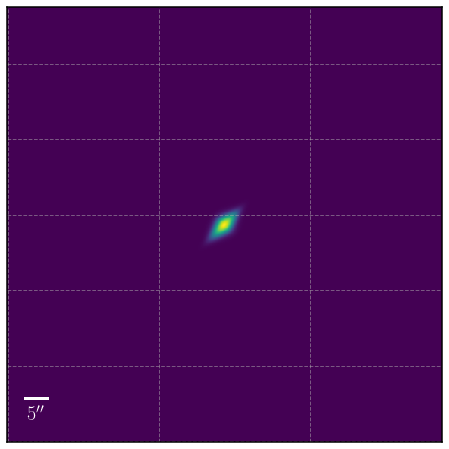

In [69]:
# Let call this model `edgeonly`
edgeonly_desc = pyimfit.SimpleModelDescription()

# Define the limits on the central-coordinate X0 and Y0 as +/-10 pixels relative to initial values
edgeonly_desc.x0.setValue(cen_x, [cen_x - 10, cen_x + 10])
edgeonly_desc.y0.setValue(cen_y, [cen_y - 10, cen_y + 10])

# Creates an Edge-on Exponential component
edgedisk = pyimfit.make_imfit_function('EdgeOnDisk')
# Set initial values, lower and upper limits of each parameters
# You can pretty much eyeball the PA of the edge on disk
edgedisk.PA.setValue(135, [0, 180])
# The L_0 should not be that different from the central flux level
edgedisk.L_0.setValue(cen_flux, [cen_flux / 5.0, cen_flux * 20.0])
edgedisk.h.setValue(5, [0.2, 100])
edgedisk.z_0.setValue(2, [0.2, 50])
edgedisk.n.setValue(1, [0.5, 50])

edgeonly_desc.addFunction(edgedisk)

# We want to pass the PSF image to the model object now
edgeonly = pyimfit.Imfit(edgeonly_desc, i_psf)

# And we can see what's our initial guess look like
model_ini = edgeonly.getModelImage(shape=img_shape)

# Not crazy compared to the real galaxy
_ = plotting.display_single(model_ini, scale='linear', contrast=1.0)

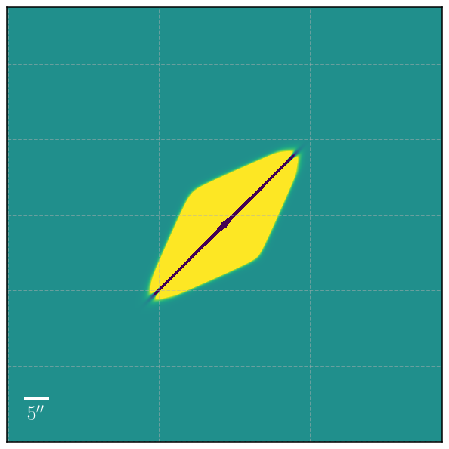

In [72]:
# Just for demonstration, we can also get a version without PSF convolution
edgeonly_nopsf = pyimfit.Imfit(edgeonly_desc) 

# And we can generate a model without PSF convolution and check the difference
model_nopsf = edgeonly_nopsf.getModelImage(shape=img_shape)

# Not crazy compared to the real galaxy
_ = plotting.display_single(model_ini - model_nopsf, contrast=0.5)

# Basically, PSF "moves" some flux from the high-intensity region to the fainter part of the galaxy.

### Pass input data to the fitter

* Pass the science image, object mask, and variance maps to the `imfit` object
* Make sure you tell `imfit` the error information is in the form of variance map.

In [73]:
edgeonly.loadData(i_img, mask=i_msk, error=i_var, error_type="variance")

### Perform the fitting. 

* You may choose from three algorithms to search the parameter spaces and find the best solution.
    1. `LM`: Levenberg-Marquardt. Standard least square algorithm. Least time-consuming, but sometime it does not gives you the real global minimum $\chi^2$ position.
    2. `NM`: Nelder-Mead Simplex. Has some advantages over `LM` but is also more time-consuming.
    3. `DE`: Differential Evolution. This algorithm will make sure to search the entire parameter spaces allowed by the model setup, so it will find you the real global minimum. But it is super slow.
    
* The fitting process can take some time. For a $600 \times 600$ image, it takes about ~5 mins on my 2015 MacBookPro.

* Right now, there is no way to interupt the fitting process...so no way to pause and restart. Please just be patient when it starts to run.

In [74]:
solver = 'NM'

edgeonly_result = edgeonly.doFit(solver=solver)

### Analysing the result

* We need to check whether the fitting process is converged: or whether the fitting algorithm thinks it finds the best solution. Most algorithms have a maximum number of iterations. If the algorithm reached that limit first, the fitting is not converged. 
* We also want to check a few fitting statistics. These values should be able to tell us "whether the model is good enough". This turns out to be a very difficult task, but it is easier to answer question like "is this model better than the other one?" This is the so-called **model selection** problem.
    - $\chi^2$ or reduced $\chi^2$ values: This is a classical statistical test for least-square fitting process, and it is well defined for **linear** problem. Reduced $\chi^2$ is the $\chi^2$ value divided by the effective degree-of-freedom (DoF) in the fitting (e.g. number of pixels used in the fitting minus the number of free parameters). But our 2-D image fitting process with PSF convoluiton is not a linear problem, and the effective DoF is not well defined, so it is not that easy to use reduced $\chi^2$ anymore. Generally speaking, we want the $\chi^2$ value to be as low as **allowed by the noise on the image**. You can read about the basics of [$\chi^2$ statistics here](http://maxwell.ucsc.edu/~drip/133/ch4.pdf). And you can read [more about the tricky nature of reduced $\chi^2$ here](https://arxiv.org/abs/1012.3754).
    - **Akaike information criterion** or **AIC** is another way to evaluate the model. You can find the mathematical definition [here](https://en.wikipedia.org/wiki/Akaike_information_criterion). But the basic idea is to "punish" the best-fit likelihood value using a term related to the number of free parameters. This way, when we compare model with different number of free parameters, we may be able to compare them objectively. Basically, we expect the model with more free parameters to be more flexible, and be able to fit the data better. But only when it is better than this naive expectation, we may consider using this more complex model.
    - **Bayesian information cirterion** or **BIC** is similar to AIC. You can read more about it [here](https://en.wikipedia.org/wiki/Bayesian_information_criterion). To put it simply, it "punishes" the best likelihood more than AIC.
* We also want to exame the best-fit parameters of the model. We first want to check they are reasonable. Just because they are the "best-fit" judged by the algorithm does not mean they are making physical sense. We also want to convert some of them into physical parameters used in analysis later. e.g. convert all the length/height to physical unit such as kpc.
* Finally, we also want to check the best-fit model image. More importantly, we want to check the **difference** between model and data. This is called the **residual** image. It is pattern and relative level compared to the noise can tell us a lot about the model.

#### Model statistics

In [91]:
if edgeonly_result.fitConverged:
    # If the fitting result converged (meaning the algorithm thinks it finds the best solution)
    # Show some fitting statistics
    print("# Chi2 satistics: {:f}".format(edgeonly_result.fitStat))
    # For a perfect model reduced chi2 value should be very close to 1.0
    print("# Reduced Chi2 satistics: {:f}".format(edgeonly_result.fitStatReduced))
    # AIC and BIC
    print("# AIC statistics: {:f}".format(edgeonly_result.aic))
    print("# BIC statistics: {:f}".format(edgeonly_result.bic))
    print("\n # Best fit parameter values:")
    if solver == 'LM':
        for name, val, err in zip(
            edgeonly.numberedParameterNames, edgeonly_result.params, edgeonly_result.paramErrs): 
            print("   {:7s}: {:f}+/-{:f}".format(name, val, err))
    else:
        for name, val in zip(edgeonly.numberedParameterNames, edgeonly_result.params): 
            print("   {:7s}: {:f}".format(name, val))
else:
    print("# Model is not converged! Please try again!")

# Chi2 satistics: 2638384.434265
# Reduced Chi2 satistics: 13.873018
# AIC statistics: 2638398.434854
# BIC statistics: 2638469.524643

 # Best fit parameter values:
   X0_1   : 279.979546
   Y0_1   : 288.580983
   PA_1   : 119.453708
   L_0_1  : 4.879380
   h_1    : 7.186638
   n_1    : 49.998507
   z_0_1  : 2.744945


#### Model image and the residual image

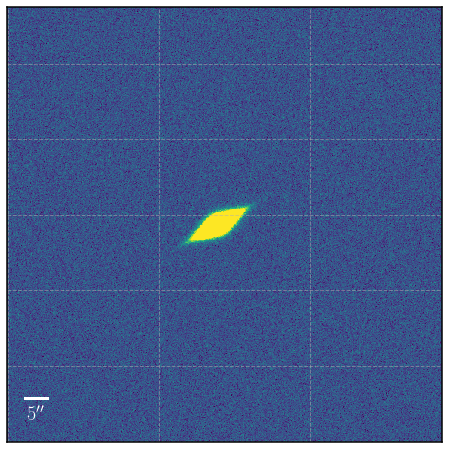

In [129]:
# Now let's see the model image
edgeonly_mod = edgeonly.getModelImage()

# Model image contains no noise, and the "background" value is determined by the numerical accuracy of some C++ code
# used in `imfit`. Something like 1E-10..this will cause problem when we try to visualize the model image directly
# We can create a fake "sky" image to add to it

i_sky = np.random.normal(loc=bkg_avg, scale=bkg_std, size=img_shape)

_ = plotting.display_single(edgeonly_mod + i_sky, contrast=0.15)

# The model and model parameters do not look crazy

In [142]:
# Now let's see the residual patterns
edgeonly_res = i_img - edgeonly_mod

# This is the relative model error information.
# It is (data - model) / error
edgeonly_chi = edgeonly_res * np.sqrt(i_var)

In [147]:
def create_circular_mask(img, center=None, radius=None):
    """Create a circular mask to apply to an image.
    
    Based on https://stackoverflow.com/questions/44865023/how-can-i-create-a-circular-mask-for-a-numpy-array
    """
    h, w = img.shape
    
    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

* Now let's zoom in to the region around our target and only look at the unmasked pixels 

Text(0.5, 0, '$\\rm (Data - Model) / \\sigma$')

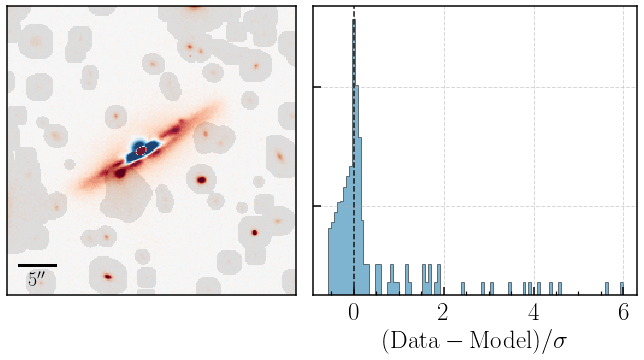

In [218]:
# Clear out the inner region
cen_mask = create_circular_mask(i_img, radius=120)

galaxy_residual = edgeonly_chi[cen_mask & (i_msk == 0)]

fig = plt.figure(figsize=(9, 4.5))
fig.subplots_adjust(left=0.0, right=1.0, bottom=0.1, top=0.99, wspace=0.0, hspace=0.0)

# Highlight the residual pattern around the galaxy
ax1 = fig.add_subplot(121)
ax1.grid(False)

# We use a different colormap to highlight features on the residual map. 
# We can use blue for negative values and red for positive values
ax1 = plotting.display_single(
    edgeonly_chi[int(cen_x - 120):int(cen_x + 120), int(cen_y - 120):int(cen_y + 120)], 
    cmap='RdBu_r', stretch='arcsinh', zmin=-0.15, zmax=0.15, ax=ax1,
    scale_bar_color='k', scale_bar_y_offset=0.3)
ax1.imshow(
    i_msk.astype('float')[int(cen_x - 120):int(cen_x + 120), int(cen_y - 120):int(cen_y + 120)], 
    origin='lower', interpolation='none', cmap='Greys', alpha=0.1)

# Show the distribution of residual levels
ax2 = fig.add_subplot(122)
ax2.axvline(0.0, linestyle='--', color='k', alpha=0.9)
_ = ax2.hist(galaxy_residual, bins=100, log=True, histtype='stepfilled',
             density=True, alpha=0.5, edgecolor='k')
ax2.set_yticklabels([])

ax2.set_xlabel(r'$\rm (Data - Model) / \sigma$', fontsize=25)

* So we can clearly see that there is still a lot of features on the residual map, which is not good...the ideal residual map should be zero everywhere. But we will never get that in real galaxy. Meanwhile, we can learn a lot from these residual patterns. You can see that the disc is not perfectly edge-on, and you can almost see there is a bulge "embeded" in it (the blue features). It takes some practice to learn enough intuition to know what's going on, but generally speaking: although the simple model is far from perfect, it is smooth and symmetric and it helps reveal a lot of "clumpy" and asymmetric structures in the residual map. 
* On the right side I show the disrtibution of the $\chi$ values in the central region of the image excluding masked out pixels. If our model is perfect, this distribution should look like just a Gaussian distribution (or normal distribution). But, in our case, it is clearly not. The distribution is highly asymmetric and has a lot of outliers at high-value end. That also suggests that this model is not perfect.

### Try a 2-component model

* Adding components means there are more free parameters to be explored, and the side effect is it takes longer time to fit the same image.

In [239]:
# Here are what these parameters named in `imfit`
print(pyimfit.imageFunctionDict['Sersic'])

['PA', 'ell', 'n', 'I_e', 'r_e']


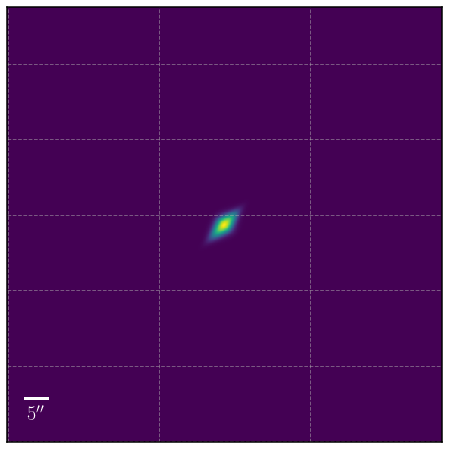

In [244]:
# Let call this model `buldgedisk`
buldgedisk_desc = pyimfit.SimpleModelDescription()

# Define the limits on the central-coordinate X0 and Y0 as +/-10 pixels relative to initial values
buldgedisk_desc.x0.setValue(cen_x, [cen_x - 10, cen_x + 10])
buldgedisk_desc.y0.setValue(cen_y, [cen_y - 10, cen_y + 10])

# Creates an Edge-on Exponential component
edgedisk = pyimfit.make_imfit_function('EdgeOnDisk')
# Set initial values, lower and upper limits of each parameters
# You can pretty much eyeball the PA of the edge on disk
edgedisk.PA.setValue(135, [0, 180])
# The L_0 should not be that different from the central flux level
edgedisk.L_0.setValue(cen_flux, [cen_flux / 5.0, cen_flux * 20.0])
edgedisk.h.setValue(5, [0.2, 100])
edgedisk.z_0.setValue(2, [0.2, 100])
edgedisk.n.setValue(1, [0.5, 500])

# Creates a Sersic component
sersic = pyimfit.make_imfit_function('Sersic')
sersic.PA.setValue(135, [0, 180])
# Ellipticity should be between 0 and 1.0
sersic.ell.setValue(0.5, [0, 1.0])
sersic.I_e.setValue(cen_flux / 2.0, [cen_flux / 10.0, cen_flux * 20.0])
sersic.r_e.setValue(2, [0.5, 50])
sersic.n.setValue(1.5, [0.5, 4.0])

buldgedisk_desc.addFunction(edgedisk)
buldgedisk_desc.addFunction(sersic)

# We want to pass the PSF image to the model object now
buldgedisk = pyimfit.Imfit(buldgedisk_desc, i_psf)

# And we can see what's our initial guess look like
model_ini = buldgedisk.getModelImage(shape=img_shape)

# Not crazy compared to the real galaxy
_ = plotting.display_single(model_ini, scale='linear', contrast=1.0)

# Chi2 satistics: 709185.855329
# Reduced Chi2 satistics: 3.729103
# AIC statistics: 709209.856969
# BIC statistics: 709331.724549

 # Best fit parameter values:
   X0_1   : 280.031658
   Y0_1   : 288.372845
   PA_1   : 120.143028
   L_0_1  : 1.486062
   h_1    : 11.378001
   n_1    : 500.000000
   z_0_1  : 3.838403
   PA_2   : 120.437938
   ell_2  : 0.734218
   n_2    : 0.772646
   I_e_2  : 100.069525
   r_e_2  : 2.485865


Text(0.5, 0, '$\\rm (Data - Model) / \\sigma$')

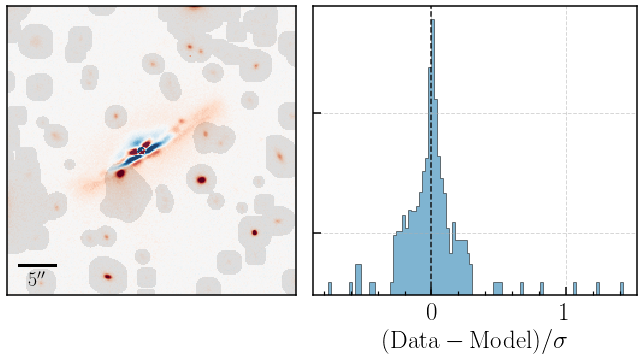

In [245]:
# Combine the data loading and fitting process
_ = buldgedisk.fit(i_img, mask=i_msk, error=i_var, error_type='variance', solver='LM', verbose=1)

if buldgedisk.fitConverged:
    # If the fitting result converged (meaning the algorithm thinks it finds the best solution)
    # Show some fitting statistics
    print("# Chi2 satistics: {:f}".format(buldgedisk.fitStatistic))
    # For a perfect model reduced chi2 value should be very close to 1.0
    print("# Reduced Chi2 satistics: {:f}".format(buldgedisk.reducedFitStatistic))
    # AIC and BIC
    print("# AIC statistics: {:f}".format(buldgedisk.AIC))
    print("# BIC statistics: {:f}".format(buldgedisk.BIC))
    print("\n # Best fit parameter values:")
    if solver == 'LM':
        for name, val, err in zip(
            buldgedisk.numberedParameterNames, buldgedisk.getRawParameters(), 
            buldgedisk.getParameterErrors()): 
            print("   {:7s}: {:f}+/-{:f}".format(name, val, err))
    else:
        for name, val in zip(buldgedisk.numberedParameterNames, buldgedisk.getRawParameters()): 
            print("   {:7s}: {:f}".format(name, val))
else:
    print("# Model is not converged! Please try again!")
    
# Model image
buldgedisk_mod = buldgedisk.getModelImage()

# Now let's see the residual patterns
buldgedisk_res = i_img - buldgedisk_mod

# This is the relative model error information.
# It is (data - model) / error
buldgedisk_chi = buldgedisk_res * np.sqrt(i_var)

# Clear out the inner region
cen_mask = create_circular_mask(i_img, radius=120)

galaxy_residual = buldgedisk_chi[cen_mask & (i_msk == 0)]

fig = plt.figure(figsize=(9, 4.5))
fig.subplots_adjust(left=0.0, right=1.0, bottom=0.1, top=0.99, wspace=0.0, hspace=0.0)

# Highlight the residual pattern around the galaxy
ax1 = fig.add_subplot(121)
ax1.grid(False)

# We use a different colormap to highlight features on the residual map. 
# We can use blue for negative values and red for positive values
ax1 = plotting.display_single(
    buldgedisk_chi[int(cen_x - 120):int(cen_x + 120), int(cen_y - 120):int(cen_y + 120)], 
    cmap='RdBu_r', stretch='arcsinh', zmin=-0.15, zmax=0.15, ax=ax1,
    scale_bar_color='k', scale_bar_y_offset=0.3)
ax1.imshow(
    i_msk.astype('float')[int(cen_x - 120):int(cen_x + 120), int(cen_y - 120):int(cen_y + 120)], 
    origin='lower', interpolation='none', cmap='Greys', alpha=0.1)

# Show the distribution of residual levels
ax2 = fig.add_subplot(122)
ax2.axvline(0.0, linestyle='--', color='k', alpha=0.9)
_ = ax2.hist(galaxy_residual, bins=100, log=True, histtype='stepfilled',
             density=True, alpha=0.5, edgecolor='k')
ax2.set_yticklabels([])

ax2.set_xlabel(r'$\rm (Data - Model) / \sigma$', fontsize=25)

* Since now we know the disk is not perfectly edge-on, so there is no good reason to force an edge-on model.

In [259]:
print(pyimfit.imageFunctionDict['BrokenExponential'])

['PA', 'ell', 'I_0', 'h1', 'h2', 'r_break', 'alpha']


# Chi2 satistics: 636464.549111
# Reduced Chi2 satistics: 3.346766
# AIC statistics: 636494.551635
# BIC statistics: 636646.885636

 # Best fit parameter values:
   X0_1   : 280.025001
   Y0_1   : 288.374999
   PA_1   : 119.453572
   ell_1  : 0.803968
   I_0_1  : 102.392265
   h1_1   : 3.823603
   h2_1   : 18.174323
   r_break_1: 7.165934
   alpha_1: 0.220666
   PA_2   : 134.726269
   ell_2  : 0.499865
   c0_2   : 0.000996
   n_2    : 5.248353
   I_e_2  : 2.720291
   r_e_2  : 9.787645


Text(0.5, 0, '$\\rm (Data - Model) / \\sigma$')

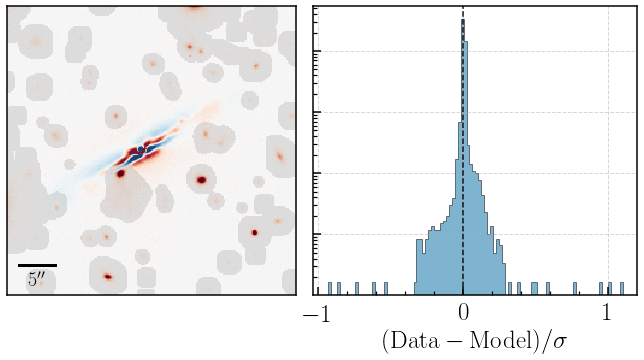

In [262]:
# Let call this model `buldgedisk2`
buldgedisk2_desc = pyimfit.SimpleModelDescription()

# Define the limits on the central-coordinate X0 and Y0 as +/-10 pixels relative to initial values
buldgedisk2_desc.x0.setValue(cen_x, [cen_x - 10, cen_x + 10])
buldgedisk2_desc.y0.setValue(cen_y, [cen_y - 10, cen_y + 10])

# Creates an Edge-on Exponential component
expdisk = pyimfit.make_imfit_function('BrokenExponential')
# Set initial values, lower and upper limits of each parameters
# You can pretty much eyeball the PA of the edge on disk
expdisk.PA.setValue(135, [0, 180])
expdisk.ell.setValue(0.2, [0, 1.0])
expdisk.I_0.setValue(cen_flux, [cen_flux / 5.0, cen_flux * 20.0])
expdisk.h1.setValue(2, [0.2, 100])
expdisk.h2.setValue(10, [0.2, 100])
expdisk.r_break.setValue(8, [0.2, 100])
expdisk.alpha.setValue(0.5, [0.2, 10.0])

# Creates a Sersic component
sersic = pyimfit.make_imfit_function('Sersic_GenEllipse')
sersic.PA.setValue(135, [0, 180])
# Ellipticity should be between 0 and 1.0
sersic.ell.setValue(0.5, [0, 1.0])
sersic.I_e.setValue(cen_flux / 2.0, [cen_flux / 10.0, cen_flux * 20.0])
sersic.r_e.setValue(2, [0.2, 50])
sersic.n.setValue(1.5, [0.2, 6.0])
sersic.c0.setValue(0.0, [-4.0, 4.0])

# Create a sky component
#flatsky = pyimfit.make_imfit_function('FlatSky')
#flatsky.I_sky.setValue(bkg_avg, [bkg_avg - 2.0 * bkg_std, bkg_avg + 2.0 * bkg_std])

buldgedisk2_desc.addFunction(expdisk)
buldgedisk2_desc.addFunction(sersic)
#buldgedisk2_desc.addFunction(flatsky)

# We want to pass the PSF image to the model object now
buldgedisk2 = pyimfit.Imfit(buldgedisk2_desc, i_psf)


# Combine the data loading and fitting process
_ = buldgedisk2.fit(i_img, mask=i_msk, error=i_var, error_type='variance', solver='LM', verbose=1)

if buldgedisk2.fitConverged:
    # If the fitting result converged (meaning the algorithm thinks it finds the best solution)
    # Show some fitting statistics
    print("# Chi2 satistics: {:f}".format(buldgedisk2.fitStatistic))
    # For a perfect model reduced chi2 value should be very close to 1.0
    print("# Reduced Chi2 satistics: {:f}".format(buldgedisk2.reducedFitStatistic))
    # AIC and BIC
    print("# AIC statistics: {:f}".format(buldgedisk2.AIC))
    print("# BIC statistics: {:f}".format(buldgedisk2.BIC))
    print("\n # Best fit parameter values:")
    if solver == 'LM':
        for name, val, err in zip(
            buldgedisk2.numberedParameterNames, buldgedisk2.getRawParameters(), 
            buldgedisk2.getParameterErrors()): 
            print("   {:7s}: {:f}+/-{:f}".format(name, val, err))
    else:
        for name, val in zip(buldgedisk2.numberedParameterNames, buldgedisk2.getRawParameters()): 
            print("   {:7s}: {:f}".format(name, val))
else:
    print("# Model is not converged! Please try again!")
    
# Model image
buldgedisk2_mod = buldgedisk2.getModelImage()

# Now let's see the residual patterns
buldgedisk2_res = i_img - buldgedisk2_mod

# This is the relative model error information.
# It is (data - model) / error
buldgedisk2_chi = buldgedisk2_res * np.sqrt(i_var)

# Clear out the inner region
cen_mask = create_circular_mask(i_img, radius=120)

galaxy_residual = buldgedisk2_chi[cen_mask & (i_msk == 0)]

fig = plt.figure(figsize=(9, 4.5))
fig.subplots_adjust(left=0.0, right=1.0, bottom=0.1, top=0.99, wspace=0.0, hspace=0.0)

# Highlight the residual pattern around the galaxy
ax1 = fig.add_subplot(121)
ax1.grid(False)

# We use a different colormap to highlight features on the residual map. 
# We can use blue for negative values and red for positive values
ax1 = plotting.display_single(
    buldgedisk2_chi[int(cen_x - 120):int(cen_x + 120), int(cen_y - 120):int(cen_y + 120)], 
    cmap='RdBu_r', stretch='arcsinh', zmin=-0.15, zmax=0.15, ax=ax1,
    scale_bar_color='k', scale_bar_y_offset=0.3)
ax1.imshow(
    i_msk.astype('float')[int(cen_x - 120):int(cen_x + 120), int(cen_y - 120):int(cen_y + 120)], 
    origin='lower', interpolation='none', cmap='Greys', alpha=0.1)

# Show the distribution of residual levels
ax2 = fig.add_subplot(122)
ax2.axvline(0.0, linestyle='--', color='k', alpha=0.9)
_ = ax2.hist(galaxy_residual, bins=100, log=True, histtype='stepfilled',
             density=True, alpha=0.5, edgecolor='k')
ax2.set_yticklabels([])

ax2.set_xlabel(r'$\rm (Data - Model) / \sigma$', fontsize=25)